In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import pandas as pd
from iminuit import Minuit
import scipy.integrate as integrate

To whomever is marking,

The top part of the notebook contains the bulk of the code, the actual answers to the questions are at the bottom and clearly labelled.

## PART 1 CODE

__class Exponential__

This class was to create the initial pdf given in the ReportDescription. It is based on the solutions released on learn. It calls for inputs that help define the pdf and contains definitions that will return the max value of the pdf, evaluate the pdf at a value of t, and evaluate the normalised pdf at the value of t. The class can be set as an object and calling the object.next() will draw a number of "events" called in the object when you create it.

In [2]:
class Exponential:
    
    # Constructor
    def __init__(self, lolim, hilim, V, m, tau, nevents):
        self.V = V
        self.m = m
        self.tau = tau
        self.lolimit = lolim
        self.hilimit = hilim
        self.nevents = nevents
        self.shape = lambda t: (1+V*np.sin(m*t))*np.exp(-t/tau)
        self.max = findMax( self.shape, self.lolimit, self.hilimit )
  
    # Returns max value of function
    def maxVal( self ) :
        return self.max

    # Evaluate method (un-normalised)
    def evaluate(self, t ):
        return self.shape(t)
 
    # Evaluate method (normalised)
    def evaluateNorm(self, t ):
        return self.shape(t) / integrate.quad( self.shape, self.lolimit, self.hilimit)[0]
    
    # Draw nevents random numbers from distribution
    def next(self):
        data  = drawSample(self, self.lolimit, self.hilimit, self.nevents)
        return data

__HELPER FUNCTIONS__

These helper functions were universal, they didn't change in any of the classes or definitions so were left outside to be called when needed. mapShape and plotShape produce graphs, drawSample creates a random sample of nevents from the pdf using the box method and findMax simply finds the max of the pdf given.

In [3]:
# A set of simple helper functions

# function to make x,y map of a shape function
def mapShape( shape, lolimit, hilimit, steps ):
    y = []
    x = []
    increment = (hilimit-lolimit)/float(steps)
    for i in range( steps ):
        t = lolimit+i*increment
        x.append(t)
        y.append(shape.evaluateNorm(t))
    return x,y
    
# To draw a random sample of N events from a pdf using box method
def drawSample(pdf, lolimit, hilimit, nevents):
    times = []
    for i in range(nevents):
        ythrow = 1.
        yval=0.
        while ythrow > yval:
            tthrow = lolimit + (hilimit-lolimit)* np.random.uniform()
            ythrow = pdf.maxVal() * np.random.uniform()
            yval =  pdf.evaluate(tthrow)
        times.append(tthrow)
    return times

# To fnd the maximum value of a function
def findMax( func, lolimit, hilimit ):
    max = 0
    grid= 100000
    dt = (hilimit-lolimit)/float(grid)
    for i in range(grid):
        if( func(lolimit+i*dt) > max ) : max = func(lolimit+i*dt)
    return max

#plots the data drawn from the drawSample def and the shape of the pdf itself
def plotShape( data, pdf, lolimit, hilimit, nbins ):
    x,y = mapShape( pdf, lolimit, hilimit, nbins )
    scaleFactor = len(data)/np.sum(y)
    y = np.multiply( y, scaleFactor )
    plt.plot(x,y)
    plt.hist(data, bins=nbins, range=[lolimit,hilimit])
    plt.show()

__singleToy__

This def creates and plots a single experiment. The one MC simulation takes values for it's input (which were given as nominal values in the ReportDiscription) which aren't changed so defined inside the def. The def creates the pdf, draws some data and plots the result.

In [4]:
# Main code to generate and plot a single experiment
def singleToy(nevents):

    #Set up intial values for the pdf
    lolimit = 0.
    hilimit = 10.
    V = 0.1 
    m = 20  
    tau = 1.5  

    #Create the pdf
    pdf = Exponential(lolimit, hilimit, V, m, tau, nevents)
    
    #Generate a single experiment
    data = pdf.next()
    
    #Plot function and data (input, function, lower limit, higher limit, bins)
    plotShape(data, pdf, lolimit, hilimit, 100 )

    #Some statistics
    averageDecayTime = np.average(data)
    print("\nThe average decay time is "+str(averageDecayTime)+'ps')
    
    #output the expected statistical precision from the experiment
    stddev =  np.std(data)
    print("\nThe expected precision of a single experiment (from stddev)is "+str(stddev))

__singleToyFile__

I essentially copy and paasted this code block from above, but with the added option of saving the data from the MC into a .txt file to be used later. My plan was to save the data to the .txt file to be used in the minimiser later and to allow for reproducability of results.

In [5]:
# Main code to generate and plot a single experiment

def singleToyFile(nevents, filename):

    #Set up intial values for the pdf
    lolimit = 0.
    hilimit = 10.
    V = 0.1 
    m = 20  
    tau = 1.5  

    #Create the pdf
    pdf = Exponential(lolimit, hilimit, V, m, tau, nevents)
    
    #Generate a single experiment
    data = pdf.next()
    file = open(filename, 'w')
    for j in range(0,len(data)):
        file.write(str(data[j])+'\n')
    file.close()
    
    #Plot function and data
    plotShape(data, pdf, lolimit, hilimit, 100 )

    #Some statistics
    averageDecayTime = np.average(data)
    print("\nThe average decay time is "+str(averageDecayTime)+"ps")
    
    #output the expected statistical precision from the experiment
    stddev =  np.std(data)
    print("\nThe expected precision of a single experiment (from stddev)is "+str(stddev))


__Multiple_MC_unedited__(number of events, number of simulations, [1 = plot graphs, anything else doesn't])

This def starts the same as singleToy, however it has a minimiser included, and runs over a multiple of MC simulations defined as nMC. This def creates a number of nMCs, saves the values for V, m and tau to a list and then takes the standard deviation of the list to find the expected precision of the experiment. There is also the option to plot the graphs of the data that the standard deviation value comes from. If set to 0, the graphs will not print, if set to 1, they will. 

I had trouble with the minimiser where it wouldn't just take V as an input, i.e.  
              m = Minuit((tmin.evaluate), V=params[0], m=params[1], tau=params[2],  
setting V=V threw an error and I didn't want to change the rest of the code so I just added V, m and tau to a list and set V, m and tau in the minimiser equal to those list indices.


In [6]:
# Main code to generate and plot a single experiment

def Multiple_MC_unedited(nevents, nMC, graphs):
    
    V_list=[]
    m_list=[]
    tau_list=[]
    for i in range(nMC):
        #Set up intial values for the pdf
        lolimit = 0.
        hilimit = 10.
        V = 0.1 
        m = 20  
        tau = 1.5  

        #Create the pdf
        pdf = Exponential(lolimit, hilimit, V, m, tau, nevents)
        data = pdf.next()
        params = [0.1,20.,1.5]
        tmin = NegLLcalc(data,normed_exp)
        # call an instance of Minuit for the new pdf and predicted values
        m = Minuit((tmin.evaluate), V=params[0], m=params[1], tau=params[2], errordef=0.5, pedantic=False, print_level=0)
        # Perform fit
        m.migrad()
        # Estimate/refine error matrix
        m.hesse()
        # Get best-fit parameter values
        V_list.append(m.values[0])
        m_list.append(m.values[1])
        tau_list.append(m.values[2])
    V_list_std = np.std(V_list)
    m_list_std = np.std(m_list)
    tau_list_std = np.std(tau_list)
    
    # condition to produce graphs, not everybody wants to see them.
    if (graphs==1):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)
        ax1.set_title('V precision')
        ax1.plot(V_list, '-o')
        ax2.set_title('m precision')
        ax2.plot(m_list, '-o')
        ax3.set_title('tau precision')
        ax3.plot(tau_list, '-o')
        plt.show()

  #  print("\nThe expected precision of %i MC simulations (from stddev)for %i events for: \nV, %.4f \nm, %.4f \ntau, %.4f " %(nMC,nevents,V_list_std,m_list_std,tau_list_std))
    
    return [V_list_std, m_list_std, tau_list_std, V_list, m_list, tau_list]

__MINIMISER__

__class NegLLcalc()__

Bases off the minimiser in the solutions on learn again. The class has a constructor that takes the data and the functions and evaluates it. The evaluate function takes V, m and tau as inputs and uses the data and the function to produce pdf2. pdf2 has constraints placed on it to prevent negative numbers, logs of 0 or NaNs. if below 0, the value input in the brackets is used and the function has no upper limit so infinity is used

In [7]:
# To calcualte an NLL from a dataset and a pdf
class NegLLcalc():

    def __init__(self,newdata,pdf):
        self.newdata = np.array(newdata)
        self.pdf = pdf
    
    def evaluate(self,V,m,tau):
        pdf2 = self.pdf(self.newdata,V,m,tau)
        pdf2 = np.clip(pdf2,0.0000000001,np.inf)
        log_pdf = np.log(pdf2)
        nll = -sum(log_pdf)
        return nll

__normed_exp__

this is just the pdf to be input into the minimiser, it has the same form as the pdf in the previous sections but normed within the function instead of outside it.

In [8]:
def normed_exp(t,V,m,tau):
    norm = (quad(lambda t: ((1.+V*np.sin(m*t))*np.exp(-t/tau)),0,10)[0])
    norm_dist = (1./norm)*((1+V*np.sin(m*t))*np.exp(-t/tau))
    return norm_dist

__myminimiser__

takes a file, specified in the call. The data is read, passed to the NegLLcalc with the normalised function and then minuit is called to perform. Minuit fits the data and estimates errors, the function then prints the values and errors to be seen where the function is called.

In [9]:
def myminimiser(filename):
    params = [0.1,20.,1.5]
    data = np.loadtxt(filename)
    tmin = NegLLcalc(data,normed_exp)
    # call an instance of Minuit for the new pdf and predicted values
    m = Minuit((tmin.evaluate), V=params[0], m=params[1], tau=params[2], errordef=0.5, pedantic=False)
    # Perform fit
    m.migrad()
    # Estimate/refine error matrix
    m.hesse()

    print("\nV= %.4f +- %.4f\n"%(m.values[0],m.errors[0]),"m= %.4f +- %.4f\n"%(m.values[1],m.errors[1]),"tau= %.4f +- %.4f"%(m.values[2],m.errors[2]))

 ## PART 2 CODE

__ExponentialGauss__

For part 2, the aim was to estimate possible bias due to time resolution. So to incorporate the resolution (or random error) with a known standard deviation we define as 0.01*tau and 0.03*tau. The bias is measured by introducing the time into the pdf and then using the minimiser but without telling it about the resolution change.

To do this, I added an extra def that draws from the drawSample def. tdep will call drawSample which will draw a value of t as normal, then tdep takes this value of t and uses it to take a different value of t from a guassian distribution centred around t_true with a width that we have already defined (I used frac, as defined in the object when given to the constructor). The new t value is drawn from another box method. The final step is to automate the process using iterate to produce a single value 10,000 times. Or however many times you like if you change nevents.

In [10]:
class ExponentialGauss:
    
    # Constructor
    def __init__(self, lolim, hilim, V, m, tau, nevents, frac):
        self.V = V
        self.m = m
        self.tau = tau
        self.lolimit = lolim
        self.nevents = nevents
        self.hilimit = hilim
        self.frac = frac
        self.shape = lambda t: (1+V*np.sin(m*t))*np.exp(-t/tau)
        self.max = findMax( self.shape, self.lolimit, self.hilimit )
  
    # Returns max value of function
    def maxVal( self ) :
        return self.max

    # Evaluate method (un-normalised)
    def evaluate(self, t ):
        return self.shape(t)
 
    # Evaluate method (normalised)
    def evaluateNorm(self, t ):
        return self.shape(t) / integrate.quad( self.shape, self.lolimit, self.hilimit)[0]
    
    # Draw data from a distribution
    def drawSampleGauss(self):
        ythrow = 1.
        yval=0.
        while ythrow > yval:
            tthrow = self.lolimit + (self.hilimit-self.lolimit)* np.random.uniform()
            ythrow = self.maxVal() * np.random.uniform()
            yval =  self.evaluate(tthrow)
        return tthrow

    # Use the drawn data to produce a more accurate value of t based on a gaussian centred on t_true
    def tdep(self):
        data = self.drawSampleGauss()
        sigma = self.frac*1.5
        yval = 0 
        ythrow = 1
        while ythrow>yval:
            tthrow = self.lolimit + (self.hilimit-self.lolimit)*np.random.uniform()
            yval = np.exp(-((tthrow-data)**2)/(2*(sigma**2)))
            ythrow = self.maxVal()* np.random.uniform()
        return tthrow

    # Loop the process to get nevents
    def iteration(self):
        decaytime=[]
        for i in range(0,self.nevents):
            decaytime.append(self.tdep())
        return(decaytime)


__singleToyGaussFile__

I used this def to produce a single run (10000 events) with the gaussian time included. It draws on plotShape to plot a graph of the data. This was mostly for just a visual to direct and ideas I might get.

In [11]:
def singleToyGaussFile(filename, frac):

    #Set up intial values for the pdf
    lolimit = 0.
    hilimit = 10.
    V = 0.1 
    m = 20  
    tau = 1.5
    nevents = 10000

    #Create the pdf
    pdf = ExponentialGauss(lolimit, hilimit, V, m, tau, nevents, frac)
    
    #Generate a single experiment
    data = pdf.iteration()
    file = open(filename, 'w')
    for j in range(0,len(data)):
        file.write(str(data[j])+'\n')
    file.close()
    
    #Plot function and data
    plotShape(data, pdf, lolimit, hilimit,100)

    #Some statistics
    averageDecayTime = np.average(data)
    print("\nThe average decay time is "+str(averageDecayTime)+"ps")
    
    #output the expected statistical precision from the experiment
    stddev =  np.std(data)
    print("\nThe expected precision of a single experiment (from stddev)is "+str(stddev))

__multiple_MC_t_Gauss__

This was my more complicated def. This def creates a number of MC sims (variable nMC) with a set number of events each (variable nevents). It was also edited to create lists of values for the parameters and their standard deviation for easier reach later. The pdf is created, then data is drawn and uses tdep and drawSample as described above. The data is then put into the minimiser and the parameters are computed. The parameters for each MC are stored into the list to allow me to calculate the std and use the raw data to plot graphs.

In [12]:
def multiple_MC_t_Gauss(frac, events, graphs):

    # Lists for parameters from the minimiser, clears the list everytime you run.
    Vg_list=[]
    mg_list=[]
    taug_list=[]
    
    # Number of MC simulations to run
    for i in range(events):
        #Set up intial values for the pdf
        lolimit = 0.
        hilimit = 10.
        V = 0.1 
        m = 20  
        tau = 1.5
        nevents = 10000

        #Create the pdf
        pdf = ExponentialGauss(lolimit, hilimit, V, m, tau, nevents, frac)

        #Generate a single experiment
        data = pdf.iteration()
        params = [0.1,20.,1.5]
        tmin = NegLLcalc(data,normed_exp)
        # call an instance of Minuit for the new pdf and predicted values
        m = Minuit((tmin.evaluate), V=params[0], m=params[1], tau=params[2], errordef=0.5, pedantic=False, print_level=0)
        # Perform fit
        m.migrad()
        # Estimate/refine error matrix
        m.hesse()
        # Add values from the minimsation to the lists.
        Vg_list.append(m.values[0])
        mg_list.append(m.values[1])
        taug_list.append(m.values[2])
    # Calculate the std from the list for the precision    
    Vg_list_std = np.std(Vg_list)
    mg_list_std = np.std(mg_list)
    taug_list_std = np.std(taug_list)
    
    # condition to plot the graphs.
    if (graphs==1):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)
        ax1.set_title('V precision')
        ax1.plot(Vg_list, '-o')
        ax2.set_title('m precision')
        ax2.plot(mg_list, '-o')
        ax3.set_title('tau precision')
        ax3.plot(taug_list, '-o')
        plt.show()

 #   print("\nThe expected precision of %i MC simulations (from stddev)for f=%.2f is, for: \nV, %.4f \nm, %.4f \ntau, %.4f" %(events,frac,Vg_list_std,mg_list_std,taug_list_std))
    
    return Vg_list_std, mg_list_std, taug_list_std, Vg_list,  mg_list, taug_list

## PART 3 CODE

At this point all the code below has been seen/explained previously

In [13]:
class ExponentialTimeAcc:
    
    # Constructor
    def __init__(self, lolim, hilim, V, m, tau, s, nevents):
        self.V = V
        self.m = m
        self.tau = tau
        self.lolimit = lolim
        self.hilimit = hilim
        self.s = s
        self.nevents = nevents
        self.shape = lambda t: ((1+V*np.sin(m*t))*np.exp(-t/tau))*(1+s*t)
        self.max = findMax( self.shape, self.lolimit, self.hilimit )
  
    # Returns max value of function
    def maxVal( self ) :
        return self.max

    # Evaluate method (un-normalised)
    def evaluate(self, t ):
        return self.shape(t)
 
    # Evaluate method (normalised)
    def evaluateNorm(self, t ):
        return self.shape(t) / integrate.quad( self.shape, self.lolimit, self.hilimit)[0]
    
    # Draw N random number from distribution
    def next(self):
        data  = drawSample(self, self.lolimit, self.hilimit, self.nevents)
        return data

In [14]:
def ToyTimeAccFile(filename, nMC, s, graphs):

    Vt_list=[]
    mt_list=[]
    taut_list=[]
    
    for i in range(nMC):
        lolimit = 0.
        hilimit = 10.
        V = 0.1 
        m = 20  
        tau = 1.5 
        nevents=10000

        #Create the pdf
        pdf = ExponentialTimeAcc(lolimit, hilimit, V, m, tau, s, nevents)

        #Generate a single experiment
        data = pdf.next()
        file = open(filename, 'w')
        for j in range(0,len(data)):
            file.write(str(data[j])+'\n')
        file.close()
        params = [0.1,20.,1.5]
        tmin = NegLLcalc(data,normed_exp)
        # call an instance of Minuit for the new pdf and predicted values
        m = Minuit((tmin.evaluate), V=params[0], m=params[1], tau=params[2], errordef=0.5, pedantic=False, print_level=0)
        # Perform fit
        m.migrad()
        # Estimate/refine error matrix
        m.hesse()
        
        Vt_list.append(m.values[0])
        mt_list.append(m.values[1])
        taut_list.append(m.values[2])
    Vt_list_std = np.std(Vt_list)
    mt_list_std = np.std(mt_list)
    taut_list_std = np.std(taut_list)
    
    if (graphs==1):
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)
        ax1.set_title('V precision')
        ax1.plot(Vt_list, '-o')
        ax2.set_title('m precision')
        ax2.plot(mt_list, '-o')
        ax3.set_title('tau precision')
        ax3.plot(taut_list, '-o')
        plt.show()

    return Vt_list_std, mt_list_std, taut_list_std, Vt_list,  mt_list, taut_list

# PART 1

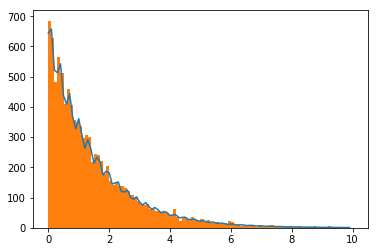


The average decay time is 1.4913226727120323ps

The expected precision of a single experiment (from stddev)is 1.4757798235506985


In [15]:
singleToyFile(10000, 'tenthoudata.txt')

This shows the sinusoidal oscillations and exponential decay. From the outset we can see the shape of the graph is what we expected and that on the surface, the code is running as it should be. The average decay time is also what we would expect, $\approx$ tau. The data is normalised but is displayed in a box plot so it is hard to see.

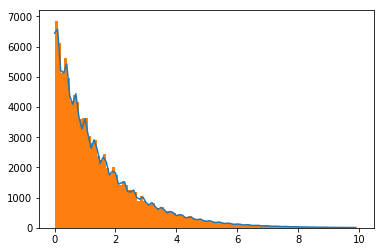


The average decay time is 1.4812078111159852ps

The expected precision of a single experiment (from stddev)is 1.454070729734958


In [16]:
singleToyFile(100000, 'hundthoudata.txt')

As you can see, from the first graph (10000 events) compared to the second graph (100000 events). The value of the average decay time gets closer to the real decay time but the expected precision is closer to the value from the data. The more events you plot, the better precision you can hope to find. It is also worth noting that at this low level of events, statistical fluctuations could cause the average decay time for the second graph to be closer to the real value than the first.

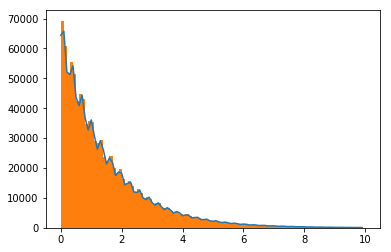


The average decay time is 1.4800201905477282ps

The expected precision of a single experiment (from stddev)is 1.4554220274576017


In [17]:
singleToy(1000000)

jusitfied by the Law of Large Numbers, the sample mean will approach the expected value with increasing events and its variance will decrease as 1/events. Thus as we increase events, the precision will get better and better.

In [18]:
myminimiser('tenthoudata.txt')

FCN = 13950.837751987141 
 TOTAL NCALL = 59 
 NCALLS = 59 
 
 
 EDM = 1.1599410075454306e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,V,0.116259,0.0142363,,,,,No
1,m,20.0958,0.0556918,,,,,No
2,tau,1.5104,0.0155847,,,,,No


+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,V,0.116259,0.0142363,,,,,No
1,m,20.0958,0.0556918,,,,,No
2,tau,1.5104,0.0155847,,,,,No


+,V,m,tau
V,1.00,-0.00,0.05
m,-0.00,1.00,-0.00
tau,0.05,-0.00,1.00



V= 0.1163 +- 0.0142
 m= 20.0958 +- 0.0557
 tau= 1.5104 +- 0.0156


The minimiser gives relatively similar errors to each of its parameters (in the sense that they are all 0.0x), however as expected, the error in m (or delta m in the ReportDescription) is much larger to match the magnitude of m compared to V and tau.

# PART 2

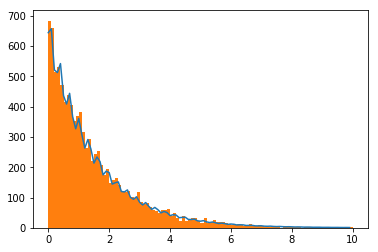


The average decay time is 1.4849322050941185ps

The expected precision of a single experiment (from stddev)is 1.4601010432645722


In [19]:
singleToyGaussFile("gaussdistdata_0.01.txt", 0.01)

This plot shows the data produced from the pdf where the gaussian time is introduced. The 0.01 in the def is for the fraction, f. The trend looks the same, the average decay time is still roughly centred on tau, with the precision now even better than PART 1.

In [20]:
myminimiser('gaussdistdata_0.01.txt')

FCN = 13912.292857224797 
 TOTAL NCALL = 46 
 NCALLS = 46 
 
 
 EDM = 3.5947664538236884e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,V,0.10784,0.0140908,,,,,No
1,m,19.9174,0.062434,,,,,No
2,tau,1.50312,0.0154964,,,,,No


+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,V,0.10784,0.0140908,,,,,No
1,m,19.9174,0.062434,,,,,No
2,tau,1.50312,0.0154964,,,,,No


+,V,m,tau
V,1.00,-0.01,0.05
m,-0.01,1.00,0.00
tau,0.05,0.00,1.00



V= 0.1078 +- 0.0141
 m= 19.9174 +- 0.0624
 tau= 1.5031 +- 0.0155


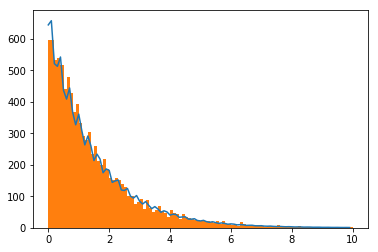


The average decay time is 1.4915659079073824ps

The expected precision of a single experiment (from stddev)is 1.4600891011670698


In [21]:
singleToyGaussFile("gaussdistdata_0.03.txt", 0.03)

Increasing f, or the width of the gaussian dist around t_true, decreases the precision of the experiment. As we can see here, the precision of the first graph (where f=0.01) is lower than compared to this graph (f=0.03).

In [22]:
myminimiser('gaussdistdata_0.03.txt')

FCN = 13980.264686792107 
 TOTAL NCALL = 61 
 NCALLS = 61 
 
 
 EDM = 2.5219001337924013e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,V,0.0465323,0.0141933,,,,,No
1,m,20.0502,0.138114,,,,,No
2,tau,1.50702,0.0155447,,,,,No


+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,V,0.0465323,0.0141933,,,,,No
1,m,20.0502,0.138114,,,,,No
2,tau,1.50702,0.0155447,,,,,No


+,V,m,tau
V,1.00,-0.00,0.05
m,-0.00,1.00,-0.00
tau,0.05,-0.00,1.00



V= 0.0465 +- 0.0142
 m= 20.0502 +- 0.1381
 tau= 1.5070 +- 0.0155


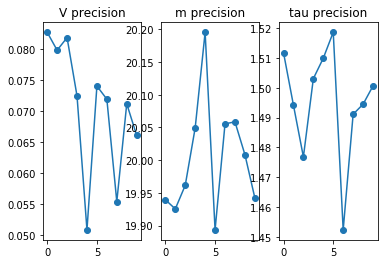

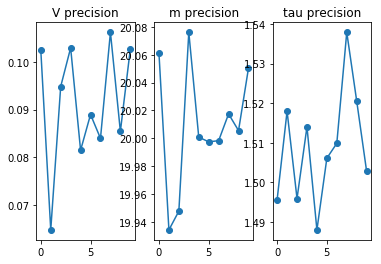

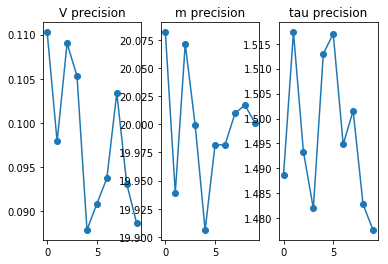

In [23]:
a = multiple_MC_t_Gauss(0.03, 10, 1)
b = multiple_MC_t_Gauss(0.01, 10, 1)
c = Multiple_MC_unedited(10000, 10, 1)

This step was to set a benchmark to compare the rest of the data to, to calculate bias and time acceptance. It may also be insightful to see the variation in the paramaters for each MC simulation in your dataset, to spot any discrepencies.

All data sets show random oscillations around their true values (or optimal values we entered).

In [24]:
print( 'Precision difference in V for 0.03/orignal: '+str(a[0]-c[0]))
print( 'For reference, the precision of V in the original was: '+str(c[0]))
print( 'For reference, the precision of V in f=0.03 was: '+str(a[0]))
print( 'Giving a percentage difference of: '+str(((a[0]-c[0])/(c[0]))*100)+'%')
print( 'Precision difference in V for 0.01/orignal: '+str(b[0]-c[0]))
print( 'Giving a percentage difference of: '+str(((b[0]-c[0])/(c[0]))*100)+'%')

Precision difference in V for 0.03/orignal: 0.0020852898169410362
For reference, the precision of V in the original was: 0.007994710766976033
For reference, the precision of V in f=0.03 was: 0.01008000058391707
Giving a percentage difference of: 26.083367838081134%
Precision difference in V for 0.01/orignal: 0.004349165410810466
Giving a percentage difference of: 54.40053477326134%


The precision difference (difference precision of parameter V in the f=0.03 pdf and parameter V in the original dataset I have defined above as c. The very low number is deceiveing as the percentage difference is actually large. $\approx$16% difference in precision is quite large. However, for the smaller value of f=0.01, the percentage difference between V and the original V was $\approx$20%. The values are also negative, meaning our precision has decreased by adding the time resolution (as you would expect).

In [25]:
print( np.abs(c[1]-a[1])) #Precision in m 0.03 - orignal
print( 'Giving a percentage difference of: '+str(((a[1]-c[1])/(c[0]))*100)+'%')
print( np.abs(c[1]-b[1])) #Precision in m 0.01 - orignal
print( 'Giving a percentage difference of: '+str(((b[1]-c[1])/(c[0]))*100)+'%')

0.034739740065424574
Giving a percentage difference of: 434.53404479527825%
0.007148711647814519
Giving a percentage difference of: -89.41801468720914%


Interestingly, for delta m, the precision increased and increased more, the higher the time resolution fraction, f, was.

In [26]:
print( np.abs(c[2]-a[2])) #Precision in tau 0.03 - orignal
print( 'Giving a percentage difference of: '+str(((a[2]-c[2])/(c[2]))*100)+'%')
print( np.abs(c[2]-b[2])) #Precision in tau 0.01 - orignal
print( 'Giving a percentage difference of: '+str(((b[2]-c[2])/(c[2]))*100)+'%')

0.004135391217511785
Giving a percentage difference of: 29.413909967677686%
0.00022824261232866003
Giving a percentage difference of: -1.6234274574540024%


Expected precision for tau increased as f increased too.

In [27]:
# difference in the mean values for V, m and tau and the percentage difference between the mean values
V_diff_zerothree = np.mean(np.array(c[3])-np.array(a[3])) #Difference in V in 0.03 - orignal
VP_diff_zerothree = ((np.mean(np.array(c[3])-np.array(a[3])))/np.mean(np.array(c[3])))*100 # % Difference in V in 0.03 - orignal
V_diff_zeroone = np.mean(np.array(c[3])-np.array(b[3])) #Difference in V in 0.01 - orignal
VP_diff_zeroone = ((np.mean(np.array(c[3])-np.array(b[3])))/np.mean(np.array(c[3])))*100 # % Difference in V in 0.01 - orignal

print("Mean and mean percentage difference in V over 10 MC simulations with 10000 events with f=0.3 and V with no f: \n%.4f, %.4f%%" %(V_diff_zerothree,VP_diff_zerothree))
print("Mean and percentage difference in V over 10 MC simulations with 10000 events with f=0.1 and V with no f: \n%.4f, %.4f%%" %(V_diff_zeroone,VP_diff_zeroone))


Mean and mean percentage difference in V over 10 MC simulations with 10000 events with f=0.3 and V with no f: 
0.0274, 27.9101%
Mean and percentage difference in V over 10 MC simulations with 10000 events with f=0.1 and V with no f: 
0.0066, 6.7577%


In [28]:
m_diff_zerothree = np.mean(np.array(c[4])-np.array(a[4])) #Difference in m in 0.03 - orignal
mP_diff_zerothree = ((np.mean(np.array(c[4])-np.array(a[4])))/np.mean(np.array(c[4])))*100 # % Difference in m in 0.03 - orignal
m_diff_zeroone = np.mean(np.array(c[4])-np.array(b[4])) #Difference in m in 0.01 - orignal
mP_diff_zeroone = ((np.mean(np.array(c[4])-np.array(b[4])))/np.mean(np.array(c[4])))*100 # % Difference in m in 0.01 - orignal

print("Mean and mean percentage difference in m over 10 MC simulations with 10000 events with f=0.3 and V with no f: \n%.4f, %.4f%%" %(m_diff_zerothree,mP_diff_zerothree))
print("Mean and percentage difference in m over 10 MC simulations with 10000 events with f=0.1 and V with no f: \n%.4f, %.4f%%" %(m_diff_zeroone,mP_diff_zeroone))


Mean and mean percentage difference in m over 10 MC simulations with 10000 events with f=0.3 and V with no f: 
-0.0040, -0.0200%
Mean and percentage difference in m over 10 MC simulations with 10000 events with f=0.1 and V with no f: 
-0.0099, -0.0495%


In [29]:
tau_diff_zerothree = np.mean(np.array(c[5])-np.array(a[5])) #Difference in tau in 0.03 - orignal
tauP_diff_zerothree = ((np.mean(np.array(c[5])-np.array(a[5])))/np.mean(np.array(c[5])))*100 # % Difference in tau in 0.03 - orignal
tau_diff_zeroone = np.mean(np.array(c[5])-np.array(b[5])) #Difference in tau in 0.01 - orignal
tauP_diff_zeroone = ((np.mean(np.array(c[5])-np.array(b[5])))/np.mean(np.array(c[5])))*100 # % Difference in tau in 0.01 - orignal

print("Mean and mean percentage difference in tau over 10 MC simulations with 10000 events with f=0.3 and V with no f: \n%.4f, %.4f%%" %(tau_diff_zerothree,tauP_diff_zerothree))
print("Mean and percentage difference in tau over 10 MC simulations with 10000 events with f=0.1 and V with no f: \n%.4f, %.4f%%" %(tau_diff_zeroone,tauP_diff_zeroone))


Mean and mean percentage difference in tau over 10 MC simulations with 10000 events with f=0.3 and V with no f: 
0.0015, 0.1016%
Mean and percentage difference in tau over 10 MC simulations with 10000 events with f=0.1 and V with no f: 
-0.0121, -0.8061%


__V__

For V, the expected precision decreased as f increased. As f increased, the mean percentage difference between the V data over each regime (between the pdf with f and the original pdf) got larger too. V appears to have the largest bias from the time resolution as the mean difference in V as a percentile is the largest. This also changes with varying values of f. For example, at f=0.3, the bias for V is $\approx$+33%

__m__

Expected precision increased with f, whilst the mean percentage difference between the original m data and the m data with f included increased, but at a much slower rate than V. Suggesting that as the time resolution increases, the expected precision increases and the delta m data follows the trend.

__tau__

Expected precision in tau also increased with increasing f. However from the mean percentage differences, it is hard to see a trend. It may be constant, it may increase but very slowly. I would need more data at different, higher fs to see.

__m/tau__

For both tau and m, the percentages remain under 1% so I cannot say for sure if there is a bias on them (unless it is very very hard to see) or they are just statistical fluctuations that increase with f and I cannot tell the difference.

__An aside__

I expect increase the number of MC simulations will also give us better results, however that would take too long to run and become more time consuming than efficient.

# PART 3

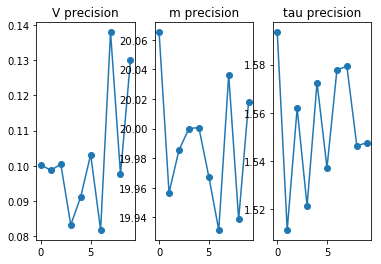

In [30]:
postime = ToyTimeAccFile('0.03timeacc.txt', 10, 0.03, 1)

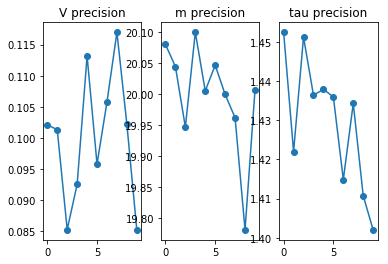

In [31]:
negtime = ToyTimeAccFile('-0.03timeacc.txt', 10, -0.03, 1)

In [32]:
Vdown = np.abs(np.average(c[3])-np.average(negtime[3]))
Vup = np.abs(np.average(c[3])-np.average(postime[3]))
V = np.mean(c[3])

In [33]:
mdown = np.abs(np.average(c[4])-np.average(negtime[4]))
mup = np.abs(np.average(c[4])-np.average(postime[4]))
m = np.mean(c[4])

In [34]:
taudown = np.abs(np.average(c[5])-np.average(negtime[5]))
tauup = np.abs(np.average(c[5])-np.average(postime[5]))
tau = np.mean(c[5])

In [35]:
print(''+str(V)+' plus '+str(Vup)+' minus '+str(Vdown))

0.09800036557581025 plus 0.004410611048877827 minus 0.002036167521293153


In [36]:
print(''+str(m)+' plus '+str(mup)+' minus '+str(mdown))

19.998978964467888 plus 0.008953051547830881 minus 0.0020618618712475723


In [37]:
print(''+str(tau)+' plus '+str(tauup)+' minus '+str(taudown))

1.4968009110023612 plus 0.05808795148254786 minus 0.06703358493740774


For Part 3, I decided to use the formula pdf*a(t) as defined in the lecture slides we have had before. I used the maximum difference and minimumum (s = 0.03,-0.03). After putting these into the pdf, I minimised without having a(t) in the pdf and did multiple MC simulations to get a fair test. I then take the data (measurements of the parameter) from each MC, and add them to a list. I take the list, average the values and end up with an averaged parameter. This average parameter has been shifted by a systematic error. Then taking the difference between the original parameter value and the new parameter value gives the error. By using +0.03 and -0.03, we get the upper and lower errors. As seen above, the value from the original experiment and the errors are shown after.

# Conclusion

By using larger numbers of events, the expected error in t decreases. Showing that more data gives more precise results. However, in future, I would like to set a seed for the random number generator to have better reproducability for when I write about the results and the results you'll actually get when you run this notebook.

The expected precision increased for m and tau as f was increased. Expected precision decreased for V and it's spread of parameters values increased with increasing f. Trends in the value difference for m and tau as f increased were hard to see as they were so much smaller than V, making a prediction about them uncertain. V was the largest biased value with a bias of $\approx$+33% for f=0.3 whilst the other parameters were sub 1%. I am unsure whether or not m and tau were biased or the effect was just statistical fluctuations.

The systematic errors due to time acceptance appear to have very little effect on the data, leaving statistical errors as the dominating errors in the experiment. For example, the statistical positive error in delta m was 0.007 compared to its value of 19.992. As a percentage that is a 0.035% change (or at least it was when I ran the notebook). Very small compared to some of the errors we have seen in V, tau and m. tau seemed to be the most effected by the time acceptance, as it had the largest errors.